<a href="https://colab.research.google.com/github/nekrut/msmb_python/blob/master/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Make sure we have latest seaborn
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [2]:
# Make sure we have latest numpy
!pip install numpy --upgrade

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.3)


In [3]:
!pip install pandas --upgrade

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [0]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# 2. Statistical Modeling
---------
In the previous chapter, the knowledge of both the generative model and the values of the parameters provided us with probabilities we could use for decision making – for instance, whether we had really found an epitope. In many real situations, neither the generative model nor the parameters are known, and we will need to estimate them using the data we have collected. Statistical modeling works from the data upwards to a model that might plausibly explain the data (Even if we have found a model that perfectly explains all our current data, it could always be that reality is more complex. A new set of data lets us conclude that another model is needed, and may include the current model as a special case or approximation). This upward-reasoning step is called statistical inference. This chapter will show us some of the distributions and estimation mechanisms that serve as building blocks for inference. Although the examples in this chapter are all parametric (i.e., the statistical models only have a small number of unknown parameters), the principles we discuss will generalize.

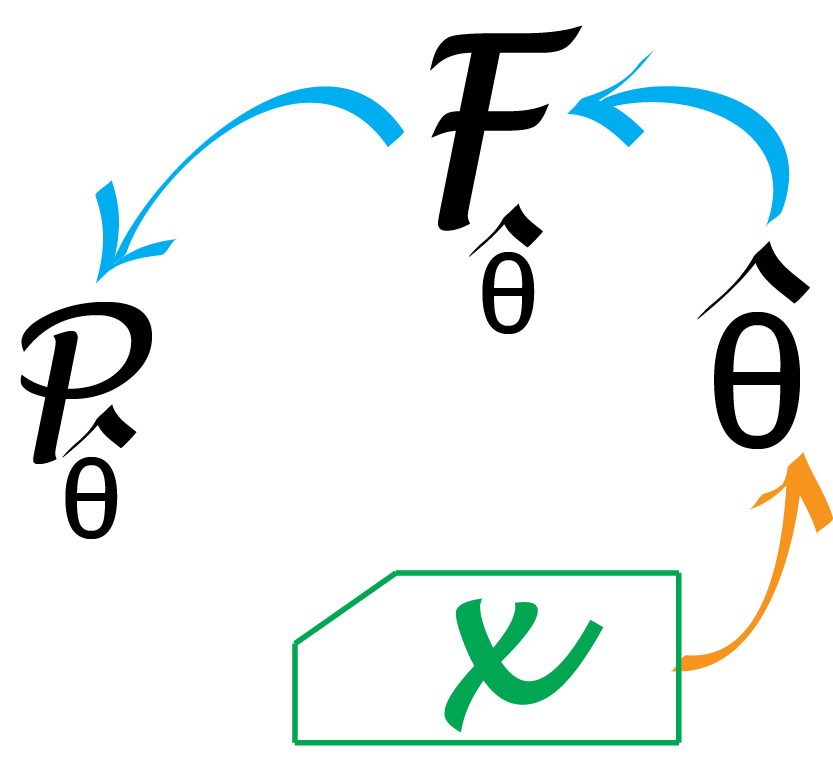

In [6]:
display(Image('http://web.stanford.edu/class/bios221/book/images/StatDiagram.png',width=300, height=300))


In a statistical setting, we start with the data $X$ and use them to estimate the parameters. These estimates are denoted by Greek letters with what we call hats on them, as in $\hat{\theta}$.

## 2.1. Goals of this chapter
--------
In this chapter we will:

 - See that there is a difference between two subjects that are often confused: “Probability” and “Statistics”.
 - Fit data to probability distributions using histograms and other visualization tricks.
 - Have a first encounter with an estimating procedure known as maximum likelihood through a simulation experiement.
 - Make inferences from data for which we have prior information. For this we will use the Bayesian paradigm which will involve new distributions with specially tailored properties. We will use simulations and see how Bayesian estimation differs from simple application of maximum likelihood.
 - Use statistical models and estimation to evaluate dependencies in binomial and multinomial distributions.
 - Analyse some historically interesting genomic data assembled into tables.
 - Make Markov chain models for dependent data.
 - Do a few concrete applications counting motifs in whole genomes and manipulate special Bioconductor classes dedicated to genomic data.
 
Parameters are the key. $\lambda$, $\mu$, $\theta$ are examples of parameters. he single parameter $\lambda$ defines a Poisson distribution. The letter $\mu$ is often used for the mean of the normal. More generally, we use the Greek letter $\theta$ to designate a generic tuple of parameters necessary to specify a probability model. For instance, in the case of the binomial distribution, $\theta = (n,p)$ comprises two numbers, a positive integer and a real number between 0 and 1.

We saw in Chapter 1 that the knowledge of all the parameter values in the epitope example enabled us to use our probability model and test a null hypothesis based on the data we had at hand. We will see different approaches to statistical modeling through some real examples and computer simulations, but let’s start by making a distinction between two situations depending on how much information is available.

## 2.2. The difference between statistical and probabilistic models
---------
A probabilistic analysis is possible when we know a good generative model for the randomness in the data, and we are provided with the parameters’ actual values.

In the epitope example, knowing that false positives occured as Bernoulli(0.01) per position, the number of patients assayed and the length of the protein ensured that there were no unknown parameters.

In such a case, we can use mathematical deduction to compute the probability of an event as schematized in Figure 2.1 below. In the epitope examples, we used the Poisson probability as our null model with the given parameter $\lambda = 0.5$. We were able to conclude through mathematical deduction that the chances of seeing a maximum value of $7$ or larger was around $10^{-4}$ and thus that in fact the observed data were highly unlikely under that model (or “null hypothesis”).

Now suppose that we know the number of patients and the length of the proteins (these are given by the experimental design) but not the distribution itself and the false positive rate. Once we observe data, we need to go up from the data to estimate both a probability model $F$ (Poisson, normal, binomial) and eventually the missing parameter(s) for that model. This is the type of statistical inference we will explain in this chapter.

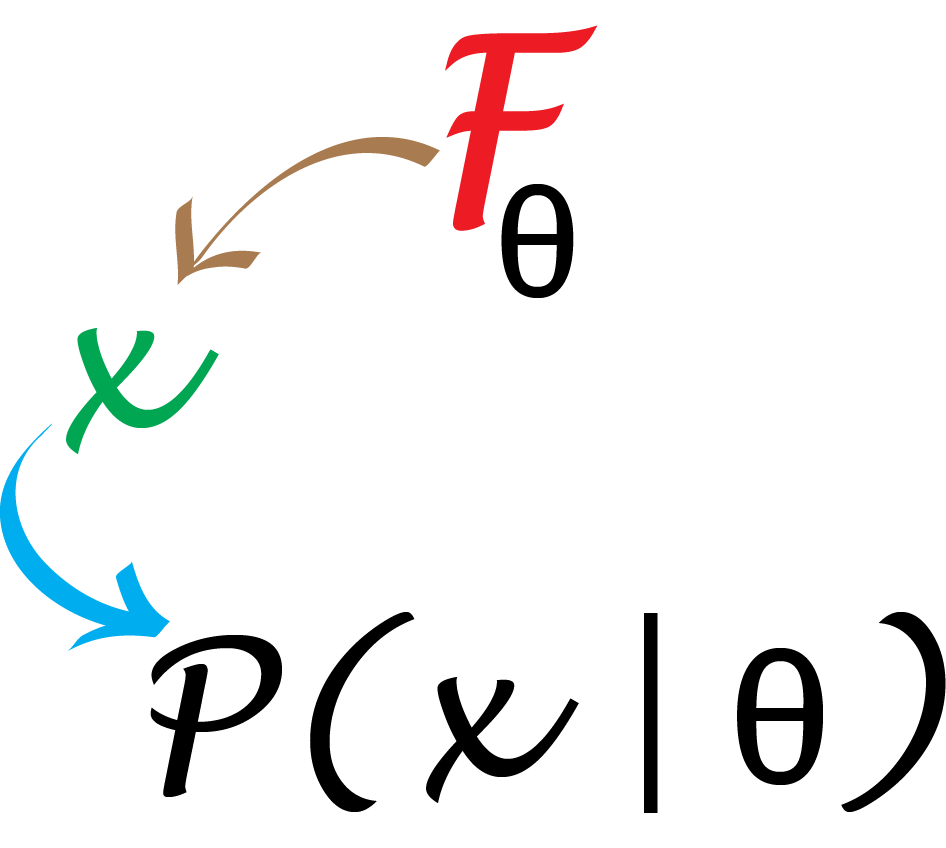

In [7]:
display(Image('http://web.stanford.edu/class/bios221/book/images/ProbaDiagram.png',width=300, height=300))

>**Figure 2.1**. The probabilistic model we obtained in Chapter 1. The data are represented as $x$ in green. We can use the observed data to compute the probability of observing $x$ when we know the true value of $\theta$.



## 2.3. A simple example of statistical modeling
-------
Start with the data

There are two parts to the modeling procedure. First we need a reasonable probability distribution to model the data generation process. As we saw in Chapter 1, discrete count data may be modeled by simple probability distributions such as binomial, multinomial or Poisson distributions. The normal distribution, or bell shaped curve, is often a good model for continuous measurements. Distributions can also be more complicated mixtures of these elementary ones (more on this in Chapter 4).

Let’s revisit the epitope example from the previous chapter, starting without the tricky outlier.

In [8]:
!pip install pyreadr

    100% |████████████████████████████████| 266kB 12.5MB/s 


In [9]:
!wget https://github.com/nekrut/msmb_python/raw/master/data/e100.RData

--2019-04-26 15:04:45--  https://github.com/nekrut/msmb_python/raw/master/data/e100.RData
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nekrut/msmb_python/master/data/e100.RData [following]
--2019-04-26 15:04:45--  https://raw.githubusercontent.com/nekrut/msmb_python/master/data/e100.RData
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129 [application/octet-stream]
Saving to: ‘e100.RData’

e100.RData          100%[===================>]     129  --.-KB/s    in 0s      

2019-04-26 15:04:45 (19.8 MB/s) - ‘e100.RData’ saved [129/129]



In [0]:
import pyreadr
df = pyreadr.read_r('e100.RData')['e100']

In [0]:
e99 = df[df['e100']<7]

Goodness-of-fit : visual evaluation

Our first step is to find a fit from candidate distributions; this requires consulting graphical and quantitative goodness-of-fit plots. For discrete data, we can plot a barplot of frequencies (for continuous data, we would look at the histogram) as in Figure 2.2:

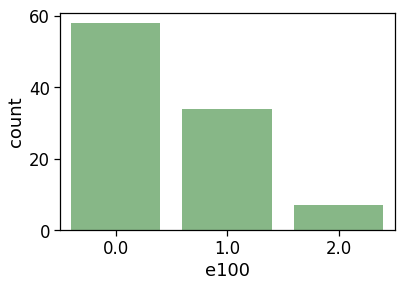

In [12]:
sns.countplot(e99['e100'], color='g', alpha=0.5)

>**Figure 2.2.** The observed distribution of the epitope data without the outlier.

However, it is hard to decide which theoretical distribution fits the data best without using a comparison. One visual goodness-of-fit diagram is known as the rootogram (Cleveland 1988); it hangs the bars with the observed counts from the theoretical red points. If the counts correspond exactly to their theoretical values, the bottom of the boxes will align exactly with the horizontal axis.

In [0]:
mlest = e99['e100'].mean()

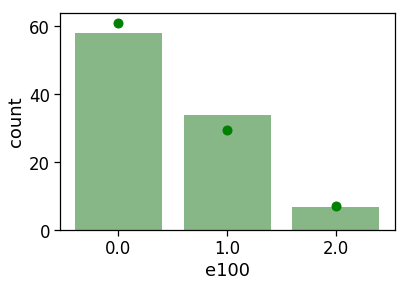

In [14]:
from scipy.stats import poisson
k = np.arange(e99['e100'].max()+1)
sns.countplot(e99['e100'], order=k, color='g', alpha=0.5)
plt.plot(k, poisson.pmf(k, mlest)*len(e99), 'go', markersize=9)

We see that the rootogram for e99 seems to fit the Poisson model reasonably well. But remember, to make this happen we removed the outlier. The Poisson is completely determined by one parameter, often called the Poisson mean $\lambda$. In most cases where we can guess the data follows a Poisson distribution, we will need to estimate the Poisson parameter from the data.

The parameter is called the Poisson mean because it is the mean of the theoretical distribution and, as it turns out, is estimated by the sample mean. This overloading of the word is confusing to everyone.

The most common way of estimating $\lambda$ is to choose the value $\hat{\lambda}$ that makes the observed data the most likely. This is called the maximum likelihood estimator (Rice 2006 Chapter 8, Section 5), often abbreviated MLE. We will illustrate this rather paradoxical idea in the next section.

Although we above took out the extreme observation before taking a guess at the probability distribution, we are going to return to the data with it for the rest of our analysis. In practice we would not know whether there is an outlier, and which data point(s) it is / they are. The effect of leaving it in is to make our estimate of the mean higher. In turns this would make it more likely that we’d observe a value of 7 under the null model, resulting in a larger p-value. So, if the resulting p-value is small even with the outlier included, we are assured that our analysis is up to something real. We call such a tactic being conservative: we err on the side of caution, of not detecting something.

#### Estimating the parameter of the Poisson distribution

What value for the Poisson mean makes the data the most probable? In a first step, we tally the outcomes:

In [15]:
df['e100'].value_counts()

0.0    58
1.0    34
2.0     7
7.0     1
Name: e100, dtype: int64

Then we are going to try out different values for the Poisson mean and see which one gives the best fit to our data. If the mean $\lambda$ of the Poisson distribution were 3, the counts would look something like this:

In [0]:
x,y = np.unique(poisson.rvs(mu=3,size=100),return_counts=True)

In [17]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
y

array([ 3, 13, 19, 26, 14, 11,  6,  4,  2,  2])

which has many more 2’s and 3’s than we see in our data. So we see that $\lambda=3$ is unlikely to have produced our data, as the counts do not match up so well.

&#9757;  Repeat this simulation with different values of $\lambda$ Can you find one that gives counts close to the oberved ones just by trial and error?

So we could try out many possible values and proceed by brute force. However, we’ll do something more elegant and use a little mathematics to see which value maximizes the probability of observing our data. Let’s calculate the probability of seeing the data if the value of the Poisson parameter is $m$. Since we suppose the data derive from independent draws, this probability is simply the product of individual probabilities:

$P(58 \times 0, 34 \times 1, 7 \times 2, 1 \times 7 | data\ are\ Poisson(m))=P(0)^{58} \times P(1)^{34} \times P(2)^{7} \times P(7)^1\\$
for $m=3$ we can compute this:

In [19]:
from numpy import prod
prod(poisson.pmf([0,1,2,7],mu=3)**[58,34,7,1])

1.3921432708903147e-110

&#9757; Compute the probability as above for $m=0,1,2$. Does $m$ have to be integer? Try computing the probability for $m=0.4$ for example.

This probability is the likelihood function of $\lambda$, given the data, and we write it:

$L(\lambda,x=(k_1,k_2,k_3,...))=\prod_{i=1}^{100}f(k_i)\\$

where $L$ stands for likelihood and $f(k)=e^{-\lambda}/k!$, the Poisson probability we saw earlier.

Instead of working with multiplications of a hundred small numbers, it is convenient (That’s usually true both for pencil and paper and for computer calculations.)  to take the logarithm. Since the logarithm is strictly increasing, if there is a point where the logarithm achieves its maximum within an interval it will also be the maximum for the probability.

Let’s start with a computational illustration. We compute the likelihood for many different values of the Poisson parameter. To do this we need to write a small function that computes the probability of the data for different values

In [0]:
def loglikelihood(l,data):
  return np.sum(np.log(poisson.pmf(data,mu=l)))

In [0]:
lambdas=np.linspace(0.05,0.95,100)

In [22]:
lambdas

array([0.05      , 0.05909091, 0.06818182, 0.07727273, 0.08636364,
       0.09545455, 0.10454545, 0.11363636, 0.12272727, 0.13181818,
       0.14090909, 0.15      , 0.15909091, 0.16818182, 0.17727273,
       0.18636364, 0.19545455, 0.20454545, 0.21363636, 0.22272727,
       0.23181818, 0.24090909, 0.25      , 0.25909091, 0.26818182,
       0.27727273, 0.28636364, 0.29545455, 0.30454545, 0.31363636,
       0.32272727, 0.33181818, 0.34090909, 0.35      , 0.35909091,
       0.36818182, 0.37727273, 0.38636364, 0.39545455, 0.40454545,
       0.41363636, 0.42272727, 0.43181818, 0.44090909, 0.45      ,
       0.45909091, 0.46818182, 0.47727273, 0.48636364, 0.49545455,
       0.50454545, 0.51363636, 0.52272727, 0.53181818, 0.54090909,
       0.55      , 0.55909091, 0.56818182, 0.57727273, 0.58636364,
       0.59545455, 0.60454545, 0.61363636, 0.62272727, 0.63181818,
       0.64090909, 0.65      , 0.65909091, 0.66818182, 0.67727273,
       0.68636364, 0.69545455, 0.70454545, 0.71363636, 0.72272

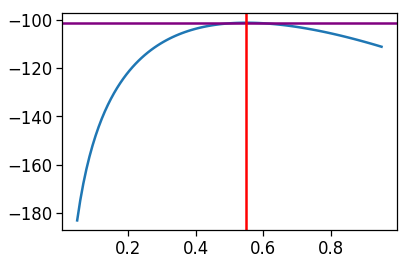

In [23]:
g = sns.lineplot(x=lambdas, y=([ loglikelihood(x,df['e100']) for x in lambdas ]))
g.axhline(loglikelihood(0.55,df['e100']),color='purple')
g.axvline(np.mean(df['e100']),color='r')

### 2.3.1. Classical statistics for classical data

Here is a formal proof of our computational finding that the mean maximizes the (log-)likelihood:

$logL(\lambda,x)=\sum_{i=1}^{100}-\lambda+k_ilog\lambda-log(k_i!)=\\
= -100\lambda+log\lambda(\sum_{i=i}^{100}k_i)+const.$

We use the catch-all “const.” for terms that do not depend on $\lambda$ (although they do depend on $x$, i.e., on the $k_i$).  To find the $\lambda$ that maximizes this, we compute the derivative in $\lambda$ and set it to zero:

$\frac{d}{d\lambda}logL=-100+\frac{1}{\lambda}\sum_{i=1}^{100}k_i=0//
\lambda=\frac{1}{100}\sum_{i=1}^{100}k_i=\bar{k}\\$

You have just seen the first steps of a *statistical approach*, starting "from the ground up" (from the data) to infer the model parameter(s): this is statistical *estimation* a parameter from data. Another important component will be choosing which family of distributions our data come from, that part is done by evaluating the *goodness of fit*. We will encounter this later.

In the classical *statistical* testing framework, we consider one single model, that we call the *null model*, for the data. The null model formulates an “uninteresting” baseline, such as that all observations come from the same random distribution regardless of which group or treatment they are from. We then test whether there is something more interesting going on by computing the probability that the data are compatible with that model. Often, this is the best we can do, since we do not know in sufficient detail what the “interesting”, non-null or alternative model should be. In other situations, we have two competing models that we can compare, as we will see later.

Another useful direction is regression. We may be interested in knowing how our count-based response variable (e.g., the result of counting sequencing reads) depends on a continuous covariate, say, temperature or nutrient concentration. You may already have encountered linear regression, where our model is that the response variable $y$ depends on the covariate $x$ via the equation $y=ax+b+e$, with parameters $a$ and $b$ (that we need to estimate), and with residuals $e$ whose probability model is a normal distribution (whose variance we usually also need to estimate). For count data the same type of regression model is possible, although the probability distribution for the residuals then needs to be non-normal. In that case we use the generalized linear models framework. We will see examples when studying RNA-Seq in Chapter 8 and another type of next generation sequencing data, 16S rRNA data, in Chapter 9.

Knowing that our probability model involves a Poisson, binomial, multinomial distribution or another parametric family will enable us to have quick answers to questions about the parameters of the model and compute quantities such as p-values and confidence intervals.

## 2.4. Binomial distributions and maximum likelihood
-------
In a binomial distribution there are two parameters: the number of trials $n$, which is typically known, and the probability $p$ of seeing a 1 in a trial. This probability is often unknown.

### 2.4.1. An example

Suppose we take a sample of $n=120$ males and test them for red-green colorblindness. We can code the data as 0 if the subject is not colorblind and 1 if he is. We summarize the data by the table:

In [0]:
cb = np.hstack((np.zeros(110),np.ones(10)))

In [25]:
cb

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [26]:
np.unique(cb,return_counts=True)

(array([0., 1.]), array([110,  10]))

&#9757; Which value of $p$ is the most likely given these data?

In this special case, your intuition may give you the estimate $\hat p=\frac{1}{12}$, which turns out to be the maximum likelihood estimate. We put a hat over the letter to remind us that this is not (necessarily) the underlying true value, but an estimate we make from the data.

As before in the case of the Poisson, if we compute the likelihood for many possible $p$, we can plot it and see where its maximum falls:

In [0]:
probs = np.arange(0,0.301,step=0.005)

In [0]:
from scipy.stats import binom
likelihood=binom.pmf(k=np.sum(cb),n=len(cb),p=probs)

[Text(0, 0.5, 'likelihood'), Text(0.5, 0, 'probaility of success')]

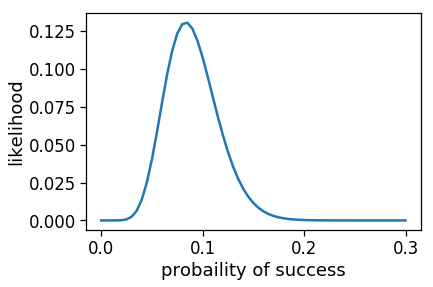

In [29]:
g=sns.lineplot(x=probs, y=likelihood)
g.set(xlabel="probaility of success",ylabel="likelihood")

>**Figure 2.5.** Plot of the likelihood as a function of the probabilities. The likelihood is a function on $[0,1]$; here we have zoomed into the range of $[0,0.3]$, as the likelihood is practically zero for larger values of $p$.

In [30]:
probs[np.argmax(likelihood)]

0.085

Note: 0.085 is not exactly the value we expected ($\frac{1}{12}$), and that is because the set of values that we tried (in probs) did not include the exact value of 
$\frac{1}{12}\simeq0.0833$, so we obtained the next best one. We could use numeric optimisation methods to overcome that.

#### Likelihood for the binomial distribution
 
One can come up with different criteria than ML, which lead to other estimators: they all carry hats. We'll see other examples in Chapter 4. The likelihood and the probability are the same mathematical function, only interpreted in different ways – in one case, it tells us how probable it is to see a particular set of values of the data, given the parameters; in the other case, we consider the data as fixed, and ask for the particular parameter value that makes the data more likely. Suppose 
$n=300$, and we observe $y=40$ successes. Then, for the binomial distribution:

$f(\theta|n,y)=f(y|n,\theta)=\binom{n}{y}\theta^y(1-\theta)^{(n-y)}.\ \ \ \ \ \ (2.5)$

As $\binom{n}{y}$ is very large (It's around $e^{115}$ , and this can be seen from Stirling’s formula.) we use the logarithm of the likelihood to give:

$logF(\theta|y)=115+40log(\theta)+(300-40)log(1-\theta)$.

Here’s a function we use to calculate it:

In [0]:
def loglikelihood(theta, n=300,k=40):
  return(115+k*np.log(theta)+(n-k)*np.log(1-theta))

In [0]:
thetas=np.arange(0,1,step=0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


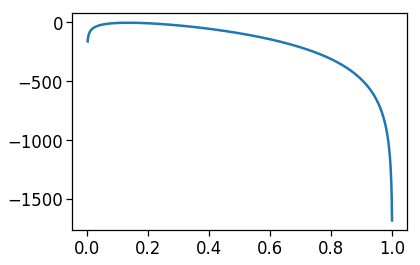

In [33]:
sns.lineplot(x=thetas,y=loglikelihood(thetas))

>**Figure 2.6.** Plot of the log likelihood function for $n=300$ and $y=40$.

The maximum lies at 40/300 = 0.1333… , consistent with intuition, but we see that other values of $\theta$ are almost equally likely, as the function is quite flat around the maximum. We will see in a later section how Bayesian methods allow us to use a range of values for $\theta$.

## 2.5. More boxes: multinomial data
---------------

### 2.5.1. DNA count modeling: base pairs

There are four basic molecules of DNA: A - adenine, C - cytosine, G - guanine, T - thymine. The nucleotides are classified into 2 groups: purines (A and G) and pyrimidines (C and T). The binomial would work as a model for the purine/pyrimidine groupings but not if we want to use A, C, G, T; for that we need the multinomial model from 1.4. Let’s look at noticeable patterns that occur in these frequencies.

### 2.5.2. Nucleotide bias

This section combines estimation and testing by simulation in a real example. Data from one strand of DNA for the genes of *Staphylococcus aureus* bacterium are available in a fasta file `staphsequence.ffn.txt`, which we can read with a function from the package [BioPython](https://biopython.org/):

In [34]:
pip install biopython

    100% |████████████████████████████████| 2.2MB 12.1MB/s 


In [35]:
!wget https://raw.githubusercontent.com/nekrut/msmb_python/master/data/staphsequence.ffn.txt

--2019-04-26 15:04:52--  https://raw.githubusercontent.com/nekrut/msmb_python/master/data/staphsequence.ffn.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788929 (2.7M) [text/plain]
Saving to: ‘staphsequence.ffn.txt’

staphsequence.ffn.t 100%[===================>]   2.66M  --.-KB/s    in 0.06s   

2019-04-26 15:04:53 (45.7 MB/s) - ‘staphsequence.ffn.txt’ saved [2788929/2788929]



In [0]:
from Bio import SeqIO
with open('staphsequence.ffn.txt','r') as handle:
  genes = list(SeqIO.parse(handle,"fasta"))

Let's look at the first gene:

In [37]:
genes[0]

SeqRecord(seq=Seq('ATGTCGGAAAAAGAAATTTGGGAAAAAGTGCTTGAAATTGCTCAAGAAAAATTA...TAA', SingleLetterAlphabet()), id='lcl|NC_002952.2_cdsid_YP_039478.1', name='lcl|NC_002952.2_cdsid_YP_039478.1', description='lcl|NC_002952.2_cdsid_YP_039478.1 [gene=dnaA] [protein=chromosomal replication initiation protein] [protein_id=YP_039478.1] [location=517..1878]', dbxrefs=[])

In [38]:
[genes[0].seq.count(x) for x in 'ACGT']

[522, 219, 229, 392]

Due to their different physcal properties, evolutionary selection can act on the nucleotide frequencies. So we can ask whether, say, the first ten genes from these data come from the same multinomial. We do not have a prior reference, we just want to decide whether the nucleotides occur in the same proportions in the first 10 genes. If not, this would provide us with evidence for varying selective pressure on these ten genes.

In [0]:
import pandas as pd
tab10 = pd.DataFrame(index=('A','C','G','T'))

In [0]:
for i, gene in enumerate(genes[:10]):
  tab10['gene{}'.format(i)] = [gene.seq.count(x) for x in 'ACGT']

In [41]:
tab10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,522,413,85,411,685,887,275,510,487,191
C,219,176,31,168,293,395,137,244,180,111
G,229,193,56,207,423,586,169,316,263,142
T,392,352,74,327,531,793,250,445,357,252


In [0]:
prop10 = (tab10/tab10.sum()).round(2)

In [43]:
prop10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,0.38,0.36,0.35,0.37,0.35,0.33,0.33,0.34,0.38,0.27
C,0.16,0.16,0.13,0.15,0.15,0.15,0.16,0.16,0.14,0.16
G,0.17,0.17,0.23,0.19,0.22,0.22,0.20,0.21,0.20,0.20
T,0.29,0.31,0.30,0.29,0.27,0.30,0.30,0.29,0.28,0.36


In [0]:
p0 = np.array(prop10.mean(axis=1))

In [45]:
p0

array([0.346, 0.152, 0.201, 0.299])

So let’s suppose `p0` is the vector of multinomial probabilities for all the ten genes and use a Monte Carlo simulation to test whether the departures between the observed letter frequencies and expected values under this supposition are within a plausible range.

We compute the expected counts by taking the outer product of the vector of probabilities p0 with the sums of nucleotide counts from each of the 10 columns, `cs`:

In [0]:
cs = pd.DataFrame(tab10.sum()).T

In [47]:
cs

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
0,1362,1134,246,1113,1932,2661,831,1515,1287,696


In [0]:
expectedtab10 = pd.DataFrame(index=('A','C','G','T'))

In [0]:
for column in cs:
  for value in cs[column]:
    expectedtab10[column]=[ value*x for x in p0 ]

In [0]:
expectedtab10 = expectedtab10.round()

In [51]:
expectedtab10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,471.0,392.0,85.0,385.0,668.0,921.0,288.0,524.0,445.0,241.0
C,207.0,172.0,37.0,169.0,294.0,404.0,126.0,230.0,196.0,106.0
G,274.0,228.0,49.0,224.0,388.0,535.0,167.0,305.0,259.0,140.0
T,407.0,339.0,74.0,333.0,578.0,796.0,248.0,453.0,385.0,208.0


In [0]:
randomtab10 = pd.DataFrame(index=('A','C','G','T'))

We can now create a random table with the correct column sums using the rmultinom function. This table is generated according to the null hypothesis that the true proportions are given by `p0`.

In [0]:
from scipy.stats import multinomial

In [0]:
for column in cs:
  for value in cs[column]:
    randomtab10[column]=multinomial.rvs(n=value,p=p0)

In [55]:
randomtab10

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
A,467,395,81,371,647,885,297,497,433,235
C,210,170,34,184,299,396,118,220,199,112
G,275,241,61,204,402,555,170,319,272,159
T,410,328,70,354,584,825,246,479,383,190


In [56]:
randomtab10.sum() == cs

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9
0,True,True,True,True,True,True,True,True,True,True


Now we repeat this B = 1000 times. For each table we compute our test statistic from Section 1.4.1 in Lecture 1 (the function stat) and store the results in the vector `simulstat`. Together, these values constitute our null distribution, as they were generated under the null hypothesis that `p0` is the vector of multinomial proportions for each of the 10 genes.

In [0]:
simulstat = np.zeros(1000)

In [0]:
for i in range(1000):
  for column in cs:
    for value in cs[column]:
      randomtab10[column]=multinomial.rvs(n=value,p=p0)
  simulstat[i] = ((randomtab10-expectedtab10)**2/expectedtab10).values.sum()

In [0]:
S1 = ((tab10-expectedtab10)**2/expectedtab10).values.sum()

In [60]:
S1

70.79264053150476

In [61]:
np.sum(simulstat >= S1)

0

The histogram is shown in Figure 2.7. We see that the probability of seeing a value as large as $S1=70.8$ is very small under the null model. It happened 0 times in our 1000 simulations that a value as big as `S1` occured. Thus the ten genes do not seem to come from the same multinomial model.

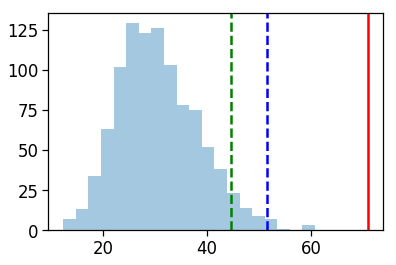

In [62]:
g = sns.distplot(simulstat, bins=20, kde=False)
g.axvline(S1,color='red')
g.axvline(np.quantile(simulstat,0.95),color='g',linestyle="--")
g.axvline(np.quantile(simulstat,0.99),color='b',linestyle="--")

>**Figure 2.7.**: Histogram of `simulstat`. The value of `S1` is marked by the vertical red line, those of the 0.95 and 0.99 quantiles (see next section) by the dotted lines.

## 2.6. The $\chi^2$ distribution
----------

In fact, we could have used statistical theory to come to the same conclusion without running these simulations. The theoretical distribution of the simulstat statistic is called the $\chi^2$ (chi-squared) distribution (Strictly speaking, the distribution of simulstat is approximately described by a $\chi^2$ distribution; the approximation is particularly good if the counts in the table are large.) with parameter 30 ($=10 \times (4-1)$). We can use this for computing the probability of having a value as large as S1 = 70.1. As we just saw above, small probabilities are difficult to compute by Monte Carlo: the granularity of the computation is $1/B$, so we cannot estimate any probabilities smaller than that, and in fact the uncertainty of the estimate is larger. So if any theory is applicable, that tends to be useful. We can check how well theory and simulation match up in our case using another visual goodness-of-fit tool: the (QQ) plot. When comparing two distributions, whether from two different samples or from one sample versus a theoretical model, just looking at histograms is not informative enough. We use a method based on the quantiles of each of the distributions.

### 2.6.1. Intermezzo: quantiles and the quantile-quantile plot

In the previous chapter, we ordered the 100 sample values $x_{(1)}, x_{(2)}, .... , x_{(100)}$. Say we want the 22nd percentile. We can take any value between the 22nd and the 23rd value, i.e., any value that fulfills $x_{(22)} \leq c_{0.22} \leq x_{(23)}$ is acceptable as a 0.22 quantile ($c_{0.22}$). In other words $c_{0.22}$ is defined by:

$ \frac{\#x'_{i}s \leq c_{0.22}}{n} = 0.22 $

Now that we have an idea what quantiles are, we can do the quantile-quantile plot. We plot the quantiles of the simulstat values, which we simulated under the null hypothesis, against the theoretical null distribution $\chi^2_{30}$
 (Figure 2.8):

In [0]:
from scipy.stats import probplot
from scipy.stats import chi2


In [0]:
x,y=probplot(simulstat,dist=chi2,sparams=(30,))[0]

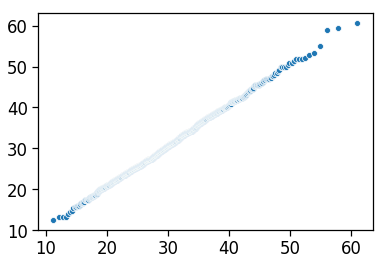

In [65]:
sns.scatterplot(x=x,y=y)

Having convinced ourselves that simulstat is well described by a $\chi^2_{30}$ distribution, we can use that to compute our $p$-value, i.e., the probability that under the null hypothesis (counts are distributed as multinomial with probabilities $p_A=0.35, p_C=0.15, p_G=0.2, p_T=0.3$ we observe a value as high as S1=70.1:

In [66]:
chi2.pdf(S1,df=30)

1.1790947465346944e-05

With such a small $p$-value, the null hypothesis seems improbable. Note how this computation did not require the 1000 simulations and was faster.

## 2.7. Chargaff's rule
---------

The most important pattern in the nucleotide frequencies was discovered by Chargaff ([Elson and Chargaff 1952](https://link.springer.com/article/10.1007/BF02170221)).

 
Long before DNA sequencing was available, using the weight of the molecules, he asked whether the nucleotides occurred at equal frequencies. He called this the tetranucleotide hypothesis. We would translate that into asking whether $p_A=p_C=p_G=p_T$.

Unfortunately, Chargaff only published the percentages of the mass present in different organisms for each of the nucleotides, not the measurements themselves.


In [67]:
!wget https://github.com/nekrut/msmb_python/raw/master/data/ChargaffTable.csv

--2019-04-26 15:05:02--  https://github.com/nekrut/msmb_python/raw/master/data/ChargaffTable.csv
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nekrut/msmb_python/master/data/ChargaffTable.csv [following]
--2019-04-26 15:05:02--  https://raw.githubusercontent.com/nekrut/msmb_python/master/data/ChargaffTable.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260 [text/plain]
Saving to: ‘ChargaffTable.csv’

ChargaffTable.csv   100%[===================>]     260  --.-KB/s    in 0s      

2019-04-26 15:05:03 (35.5 MB/s) - ‘ChargaffTable.csv’ saved [260/260]



In [0]:
chargaff = pd.read_csv('ChargaffTable.csv')

In [69]:
chargaff.head()

,Species,A,T,C,G
0,Human-Thymus,30.9,29.4,19.9,19.8
1,Mycobac.Tuber,15.1,14.6,34.9,35.4
2,Chicken-Eryth.,28.8,29.2,20.5,21.5
3,Sheep-liver,29.3,29.3,20.5,20.7
4,Sea Urchin,32.8,32.1,17.7,17.3


In [0]:
chargaff = pd.melt(chargaff,id_vars=['Species'],var_name='base',value_name='frequency')

In [71]:
chargaff.head()

,Species,base,frequency
0,Human-Thymus,A,30.9
1,Mycobac.Tuber,A,15.1
2,Chicken-Eryth.,A,28.8
3,Sheep-liver,A,29.3
4,Sea Urchin,A,32.8


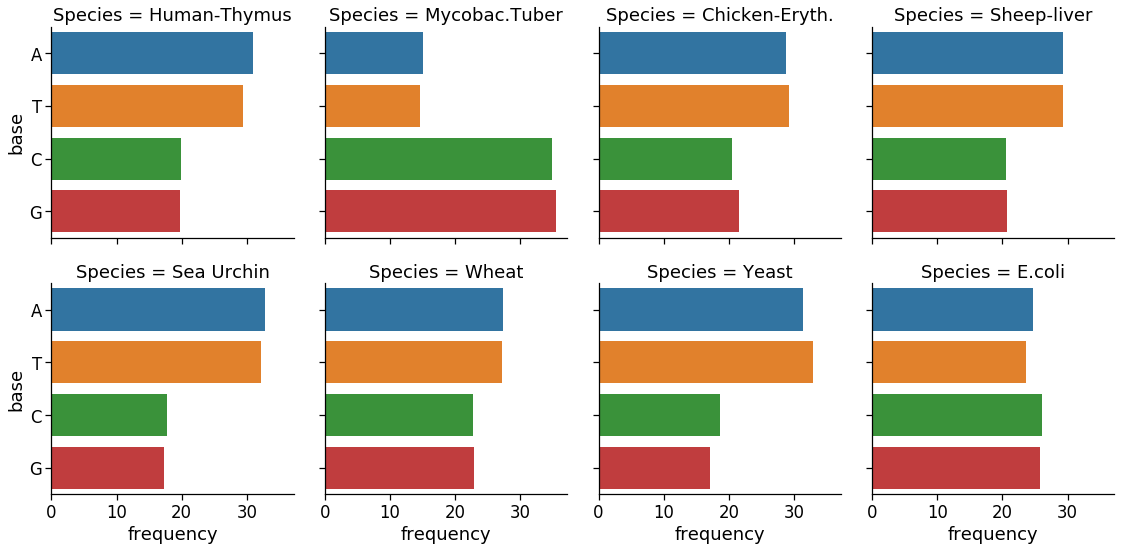

In [72]:
sns.catplot(kind='bar',x='frequency',y='base',col="Species",col_wrap=4,height=4,data=chargaff)

- Do these data seem to come from equally likely multinomial categories?
- Can you suggest an alternative pattern?
- Can you do a quantitative analysis of the pattern, perhaps inspired by the simulations above?

Chargaff saw the answer to this question and postulated a pattern called base pairing, which ensured a perfect match of the amount of adenine (A) in the DNA of an organism to the amount of thymine (T). Similarly, whatever the amount of guanine (G), the amount of cytosine (C) would be the same. This is now called Chargaff’s rule. On the other hand, the amount of C/G in an organism could be quite different from that of A/T, with no obvious pattern across organisms. Based on Chargaff’s rule, we might define a statistic:

$(p_C-p_G)^2+(p_A-p_T)^2,$

summed over all rows of the table. We are going to look at a comparison between the data and what would occur if the nucleotides were ‘exchangeable’, in the sense that the probabilities observed in each row were in no particular order, so that there were no special relationship between the proportions of As and Ts, or between those of Cs and Gs.

#### Color blindness and sex

Deuteranopia is a form of red-green color blindness due to the fact that medium wavelength sensitive cones (green) are missing. A deuteranope can only distinguish 2 to 3 different hues, whereas somebody with normal vision sees 7 different hues. A survey for this type of color blindness in human subjects produced a two-way table crossing color blindness and sex.

In [0]:
Deuteranopia = pd.DataFrame(index=['Deute','NonDeute'],data={'Men':[19,1981],'Women':[2,1998]})

In [74]:
Deuteranopia

,Men,Women
Deute,19,2
NonDeute,1981,1998


How do we test whether there is a relationship between sex and the occurrence of color blindness? We postulate the null model with two independent binomials: one for sex and one for color blindness. Under this model we can estimate all the cells’ multinomial probabilities, and we can compare the observed counts to the expected ones. This is done through the `chi2_contingency` function in `scipy.stats` package:

In [0]:
from scipy.stats import chi2_contingency

In [0]:
chi2, p, dof, ex = chi2_contingency(Deuteranopia,correction=True)

In [77]:
print('X-squared = {}, df = {}, p-value = {}'.format(chi2,dof,p))

X-squared = 12.254813963786066, df = 1, p-value = 0.000464059415494955


The small $p$ value tells us that we should expect to see such a table with only a very small probability under the null model – i.e., if the fractions of deuteranopic color blind among women and men were the same.

We’ll see another test for this type of data called Fisher’s exact test (also known as the hypergeometric test) in section 10.3.2. This test is widely used for testing the over-representations of certain types of genes in a list of significantly expressed ones.

### 2.7.2. A special multinomial: Hardy-Weinberg equilibrium

Here we highlight the use of a multinomial with three possible levels created by combining two alleles $M$ and $N$. Suppose that the overall frequency of allele M in the population is  $p$, so that of $N$ is $q=1-p$. The Hardy-Weinberg model looks at the relationship between $p$ and $q$ if there is independence of the frequency of both alleles in a genotype, the so-called Hardy-Weinberg equilibrium (HWE). This would be the case if there is random mating in a large population with equal distribution of the alleles among sexes. The probabilities of the three genotypes are then as follows:

$p_{MM}=p^2, p_{NN}=q^2, p_{MN}=2pq\ \ \ \ (2.6)$

WE only observe the frequencies $(n_{MM}, n_{NN}, n_{MN})$ for the genotrypes MM, NN, and MNand the total number $S=n_{MM}+n_{NN}+n_{MN}$. We can write the likelihood, i.e., he probability of the observed data when the probabilities of the categories are given by (2.6), using the multinomial formula:

$P(n_{MM},n_{NN},n_{NM}|p)=\binom{S}{n_{MM},n_{NN},n_{NM}}(p^2)^{n_{MM}}\times(2pq)^{n_{MN}}\times(q^2)^{n_{NN}},$

and the log-likelihood under HWE:

$L(p)=n_{MM}log(p^2)+n_{MN}log(2pq)+n_{NN}log(q^2)$

The value of $p$ that maximizes the likelihood is:

$p=\frac {n_{MM}+n_{MN}/2} {S}.$

See (Rice 2006 Chapter 8, Section 5) for the proof. Given the data $(n_{MM}, n_{NN}, n_{MN})$, the log-likelihood $L$ is a function of only one parameter, $p$. Figure 2.11 shows this log-likelihood function for different values of $p$
for the 216th row of the Mourant data (This is genotype frequency data of blood group alleles comes from [Mourant, Kopec, and Domaniewska-Sobczak (1976)](https://www.ncbi.nlm.nih.gov/pubmed/61161).




In [0]:
Mourant=pd.read_csv('https://raw.githubusercontent.com/nekrut/msmb_python/master/data/Mourant.csv')

In [79]:
Mourant[213:216]

,Population,Country,Total,MM,MN,NN
213,Oceania,Micronesia,962,228,436,298
214,Oceania,Micronesia,678,36,229,413
215,Oceania,Tahiti,580,188,296,96


In [0]:
nMM = Mourant.MM[215]
nMN = Mourant.MN[215]
nNN = Mourant.NN[215]

In [0]:
def loglik(p,mm,mn,nn):
  q = 1 - p
  return 2*mm*np.log(p)+mn*np.log(2*p*q)+2*nn*np.log(q)

In [0]:
xv = np.arange(0.01,0.99, step=0.01)

In [83]:
xv

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98])

In [0]:
yv = loglik(xv,nMM,nMN,nNN)

In [85]:
yv

array([-2894.40736343, -2433.56681537, -2166.09943481, -1977.83412219,
       -1832.99165004, -1715.63563323, -1617.26567748, -1532.80830869,
       -1458.99149515, -1393.58154869, -1334.98567855, -1282.02821618,
       -1233.81672018, -1189.65784423, -1149.00230199, -1111.40763112,
       -1076.51226649, -1044.01703633, -1013.67166882,  -985.26476475,
        -958.61622015,  -933.57141422,  -909.99669133,  -887.77580625,
        -866.80709658,  -847.00121127,  -828.27926907,  -810.57135338,
        -793.81527255,  -777.9555317 ,  -762.94247464,  -748.73156349,
        -735.28277073,  -722.56006365,  -710.53096527,  -699.16617898,
        -688.43926652,  -678.32637106,  -668.80597838,  -659.85871077,
        -651.46714885,  -643.61567767,  -636.29035385,  -629.47879123,
        -623.17006278,  -617.35461714,  -612.02420814,  -607.1718363 ,
        -602.7917012 ,  -598.879164  ,  -595.43071963,  -592.44397809,
        -589.91765476,  -587.85156952,  -586.24665482,  -585.10497277,
      

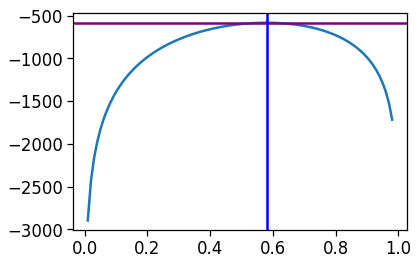

In [86]:
imax = np.argmax(yv)
g = sns.lineplot(x=xv, y=yv)
g.axhline(yv[imax],color='purple')
g.axvline(xv[imax],color='blue')

The maximum likelihood estimate for the probabilities in the multinomial is also obtained by using the observed frequencies as in the binomial case, however the estimates have to account for the relationships between the three probabilities. We can compute 
$\hat{p}_{MM}, \hat{p}_{MN}, \hat{p}_{NN}$:

In [0]:
phat = (nMM+0.5*nMN)/(nMM+nMN+nNN)

In [88]:
phat

0.5793103448275863

In [0]:
pMM = phat**2
qhat = 1 - phat

The expected values under Hardy-Weinberg equilibrium are then:

In [90]:
np.array([nMM,nMN,nNN]).sum()*np.array([phat**2,2*phat*qhat,qhat**2])

array([194.64827586, 282.70344828, 102.64827586])

which we can compare to the observed values above. We can see that they are quite close to the observed values. We could further test whether the observed values allow us to reject the Hardy-Weinberg model, either by doing a simulation or a $\chi^2$ test as above. A visual evaluation of the goodness-of-fit of Hardy-Weinberg was designed by de Finetti (Finetti 1926; Cannings and Edwards 1968). It places every sample at a point whose coordinates are given by the proportions of each of the different alleles.

In [0]:
pops = [1, 69, 128, 148, 192]

In [0]:
genotypeFrequencies = Mourant[['MM','MN','NN']].values

In [93]:
genotypeFrequencies[pops]

array([[386, 184,  34],
       [349, 512, 181],
       [261, 209,  31],
       [256, 408, 153],
       [227, 441, 224]])

In [0]:
%load_ext rpy2.ipython

In [95]:
%R library("HardyWeinberg")


Error in library("HardyWeinberg") : 
  there is no package called ‘HardyWeinberg’


/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in library("HardyWeinberg") : 
  there is no package called ‘HardyWeinberg’

  warnings.warn(x, RRuntimeWarning)


In [96]:
%%R -i Mourant
pops = c(1, 69, 128, 148, 192)
genotypeFrequencies = as.matrix(Mourant[, c("MM", "MN", "NN")])
HWTernaryPlot(genotypeFrequencies[pops, ],
        markerlab = Mourant$Country[pops],
        alpha = 0.0001, curvecols = c("red", rep("purple", 4)),
        mcex = 0.75, vertex.cex = 1)


Error in HWTernaryPlot(genotypeFrequencies[pops, ], markerlab = Mourant$Country[pops],  : 
  could not find function "HWTernaryPlot"


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in HWTernaryPlot(genotypeFrequencies[pops, ], markerlab = Mourant$Country[pops],  : 
  could not find function "HWTernaryPlot"

  warnings.warn(x, RRuntimeWarning)


### 2.7.3. Concatenating several multinomials: sequence motifs and logos

The [Kozak Motif](http://www.sciencegateway.org/resources/kozak.htm) is a sequence that occurs close to the start codon `ATG` of a coding region. The start codon itself always has a fixed spelling but in positions 5 to the left of it, there is a nucleotide pattern in which the letters are quite far from being equally likely.

We summarize this by giving the position weight matrix (PWM) or position-specific scoring matrix (PSSM), which provides the multinomial probabilities at every position. This is encoded graphically by the sequence logo (Figure 2.13).

In [0]:
kozak=pd.read_csv('https://raw.githubusercontent.com/nekrut/msmb_python/master/data/kozak.csv')

In [98]:
kozak

,A,C,T,G
0,0.33,0.12,0.33,0.22
1,0.25,0.25,0.25,0.25
2,0.40,0.10,0.40,0.10
3,0.15,0.40,0.20,0.25
4,0.20,0.40,0.25,0.15
5,1.00,0.00,0.00,0.00
6,0.00,0.00,0.00,1.00
7,0.00,0.00,1.00,0.00
8,0.05,0.05,0.90,0.00


In [99]:
%%R -i kozak
kozak = t(kozak)
library("seqLogo")
pwm = makePWM(kozak)
seqLogo(pwm, ic.scale = FALSE)


Error in library("seqLogo") : there is no package called ‘seqLogo’


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in library("seqLogo") : there is no package called ‘seqLogo’

  warnings.warn(x, RRuntimeWarning)


Over the last sections, we’ve seen how the different “boxes” in the multinomial distributions we have encountered very rarely have equal probabilities. In other words, the parameters $p_1, p_2, ...$ are often different, depending on what is being modeled. Examples of multinomials with unequal frequencies include the twenty different amino acids, blood types and hair color.

If we have multiple categorical variables, we have seen that they are rarely independent (sex and colorblindness, hair and eye color, …). We will see later in Chapter 9 that we can explore the patterns in these dependencies by using multivariate decompositions of the contingency tables. Here, we’ll look at an important special case of dependencies between categorical variables: those that occur along a sequence (or “chain”) of categorical variables, e.g., over time or along a biopolymer.

## 2.8 Modeling sequential dependencies: Markov chains
------

If we want to predict tomorrow’s weather, a reasonably good guess is that it will most likely be the same as today’s weather, in addition we may state the probabilties for various kinds of possible changes (The same reasoning can also be applied in reverse: we could “predict” yesterday’s weather from today’s.). This method for weather forecasting is an example for the Markov assumption: the prediction for tomorrow only depends on the state of things today, but not on yesterday or three weeks ago (all information we could potentially use is already contained in today’s weather). The weather example also highlights that such an assumption need not necessarily be exactly true, but it should be a good enough assumption. It is fairly straightforward to extend this assumption to dependencies on the previous $k$, where $k$ is a finite and hopefully not too large number. The essence of the Markov assumption is that the process has a finite “memory”, so that predictions only need to look back for a finite amount of time.

Instead of temporal sequences, we can also apply this to biological sequences. In DNA, we may see specific succession of patterns so that pairs of nucleotides, called digrams, say, CG, CA, CC and CT are not equally frequent. For instance, in parts of the genome we see more frequent instances of CA than we would expect under independence:

$P(CA) \neq P(C)P(A)$

We model this dependency in the sequence as a Markov chain:

$P(CA)=P(NCA)=P(NNCA)=P(...CA)=P(C)P(A|C)$

where N stands for any nucleotide, and $P(A|C)$ stands for “the probability of $A$, given that the preceding base is a $C$. Figure 2.14 shows a schematic representation of such transitions on a graph.


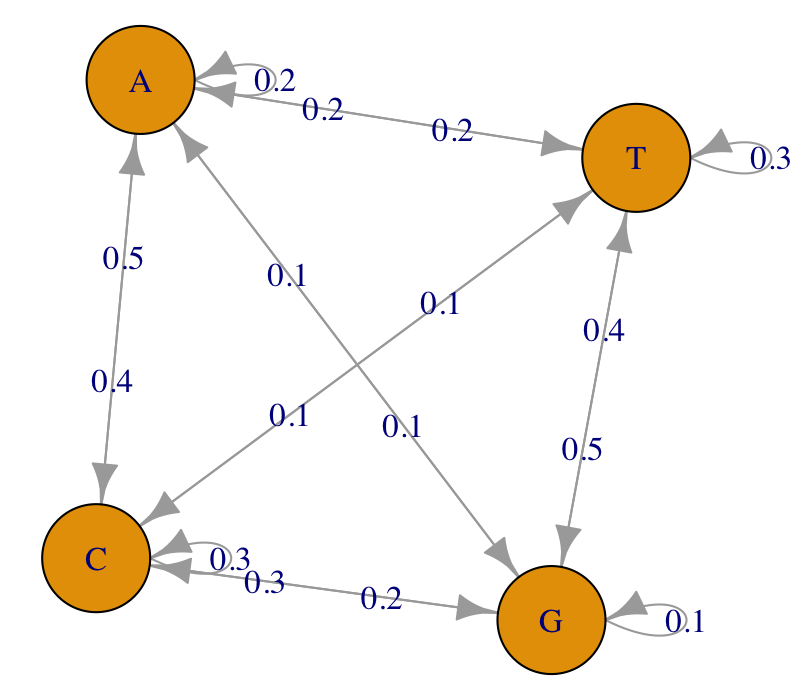

In [100]:
display(Image('http://web.stanford.edu/class/bios221/book/figure/chap2-statsfourstateMC-1.png',width=300, height=300))


> **Figure 2.14**: Visualisation of a 4-state Markov chain. The probability of each possible digram (e.,g., CA) is given by the weight of the edge between the corresponding nodes. So for instance, the probability of CA is given by the edge C → A. We’ll see in Chapter 11 how to use R packages to draw these type of network graphs.

## 2.9 Bayesian Thinking
------
Up to now we have followed a classical approach where the parameters of our distributions, i.e., the probabilities of the possible different outcomes, represent long term frequencies. The parameters are –at least conceptually– definite, knowable, fixed numbers. We may not know them, so we estimate them from the data at hand. However, such an approach does not take into account any information that we might already know, and that might constrain our parameters or make certain parameters more likely than others even before we have seen any of the current set of data. For that we need a different approach, in which we use probability distributions to express our knowledge about the parameters, and use data to update this knowledge, for instance by shifting those distributions or making them more narrow; this is provided by the Bayesian paradigm (Figure 2.15).

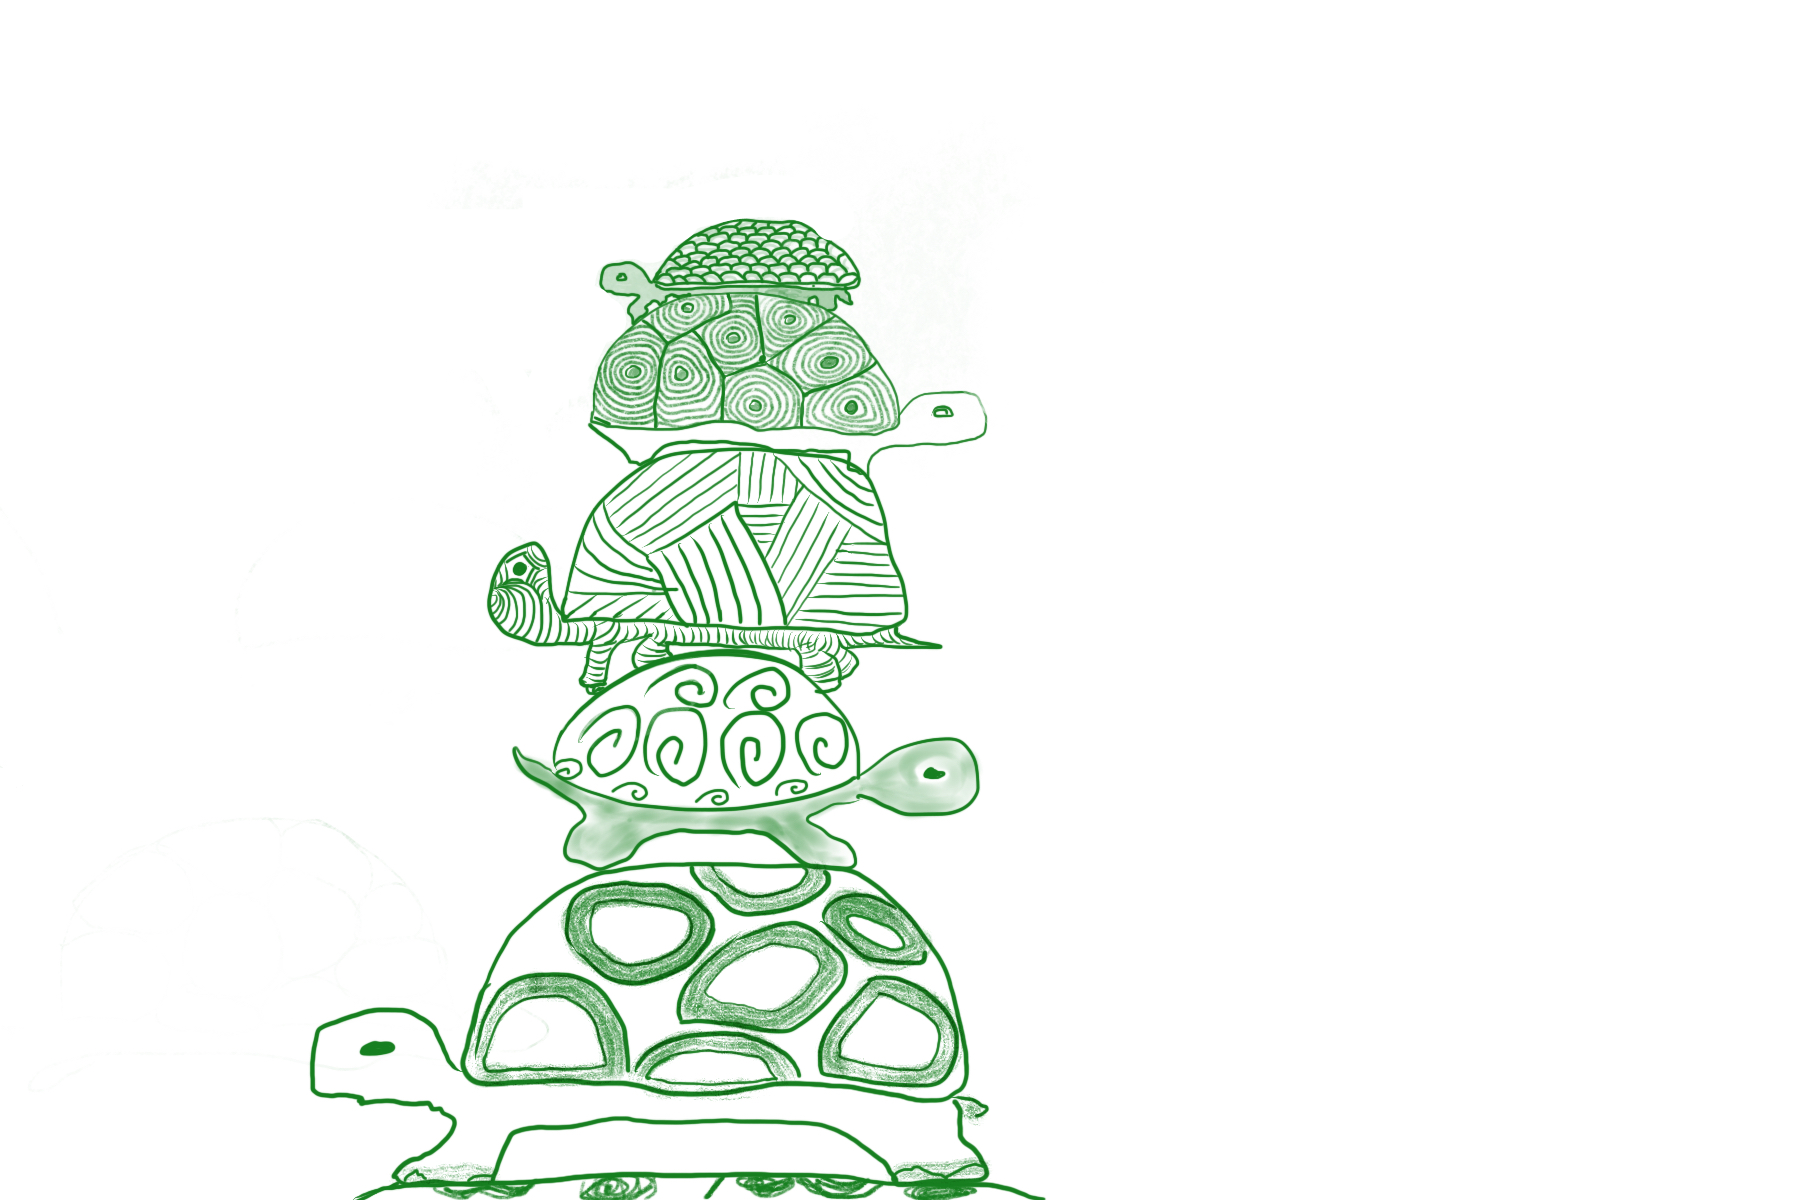

In [101]:
display(Image('http://web.stanford.edu/class/bios221/book/images/turtlesalltheway.png',width=300, height=300))

>**Figure 2.15**: Turtles all the way down. Bayesian modeling of the uncertainty of the parameter of a distribution is done by using a random variable whose distribution may depend on parameters whose uncertainty can be modeled as a random variable; these are called hierarchical models.

The Bayesian paradigm is a practical approach where prior and posterior distributions are used as models of our knowledge before and after collecting some data and making an observation. It is particularly useful for integrating or combining information from different sources.

Suppose we have a certain hypothesis, call it $H$, and we want to use data to decide whether the hypothesis is true. We can formalize our prior knowledge about $H$ in the form of a prior probability, written $P(H)$ (For a so-called frequentist, such a probability does not exist. Their viewpoint is that, although the truth is unknown, in reality the hypothesis is either true or false; there is no meaning in calling it, say, “0.7-true”.). After we see the data, we have the posterior probability. We write it as $P(H|D)$, the probability of $H$ given that we saw $D$. This may be higher or lower than $P(H)$, depending on what the data $D$ were.

#### Haplotypes

To keep the mathematical formalism to a minimum, we will start with an example. We study a forensics example using combined signatures from the Y chromosome called haplotypes.

A haplotype is a collection of alleles (DNA sequence variants) that are spatially adjacent on a chromosome, are usually inherited together (recombination tends not to disconnect them), and thus are genetically linked. In this case we are looking at linked variants on the Y chromosome.

First we’ll look at the motivation behind haplotype frequency analyses, then we’ll revisit a little the idea of likelihood. After this, we’ll explain how we can think of unknown parameters as being random numbers themselves, modeling their uncertainty with a prior distribution. Then we will see how to incorporate new data observed into the probability distributions and compute posterior confidence statements about the parameters.

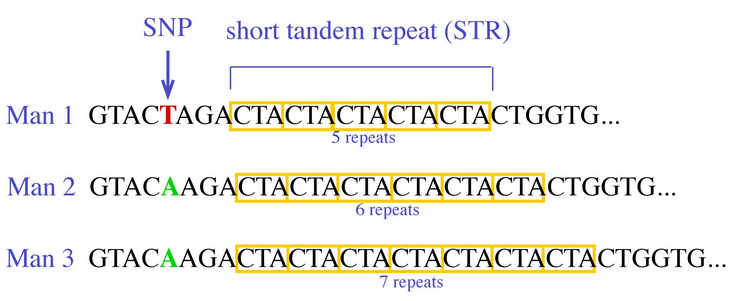

In [102]:
display(Image('http://web.stanford.edu/class/bios221/book/images/STRDefinition.png',width=700, height=300))

>**Figure 2.16**: A short tandem repeat (STR) in DNA occurs when a pattern of two or more nucleotides is repeated and the repeated sequences are directly adjacent to each other. An STR is also known as a microsatellite. The pattern can range in length from 2 to 13 nucleotides, and the number of repeats is highly variable across individuals. STR numbers can be used as genetic signatures, called haplotypes.

### 2.9.1 Example: haplotype frequencies

We want to estimate the proportion of a particular Y-haplotype that consists of a set of different short tandem repeats (STR). The combination of STR numbers at the specific STR locations used for DNA forensics are labeled by the number of repeats at the specific positions. The US Y-chromosome STR database can be accessed at the URL urlhttp://www.usystrdatabase.org. Here is a short excerpt of an STR haplotype table.

In [0]:
haplo6=pd.read_csv(filepath_or_buffer="https://raw.githubusercontent.com/nekrut/msmb_python/master/data/haplotype6.txt",sep="\t")

In [104]:
haplo6

,Individual,DYS19,DXYS156Y,DYS389m,DYS389n,DYS389p
0,H1,14,12,4,12,3
1,H3,15,13,4,13,3
2,H4,15,11,5,11,3
3,H5,17,13,4,11,3
4,H7,13,12,5,12,3
5,H8,16,11,5,12,3


This says that the haplotype H1 has 14 repeats at position DYS19, 12 repeats at position DXYS156Y and so on. (The haplotypes created through the use of these Y-STR profiles are shared between men in the same patriarchal lineages.For these reasons it is possible that two different men share the same profile.). We need to find the underlying proportion $\theta$ of the haplotype of interest in the population of interest. We are going to consider the occurrence of a haplotype as a "success" in a binomial distribution using collected observations.

### 2.9.2 Simulation study of the Bayesian paradigm for the binomial

Instead of assuming that our parameter $\theta$ has one single value, the Bayesian world view allows us to see it as a draw from a statistical distribution. The distribution expresses our belief about the possible values of the parameter $\theta$. In principle, we can use any distribution that we like whose possible values are permissible for $\theta$. When we are looking at a parameter that expresses a proportion or a probability, and which takes its values between 0 and 1, it is convenient to use the beta distribution.

Its density formula is written:

$$f_{\alpha, \beta} = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}\ \  where\ \ B(\alpha,\beta)=\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$$

We can see in Figure 2.17 how this function depends on two parameters $\alpha$ and $\beta$ making it a very flexible family of distributions (so it can ‘fit’ a lot different situations). It has a nice mathematical property: if we start with a prior belief on $\theta$ that is beta-shaped, observe a dataset of $n$ binomial trials, then update our belief, the posterior distribution on $\theta$ will also have a beta distribution, albeit with updated parameters. This is a mathematical fact, we will not prove it, however we demonstrate it by simulation.

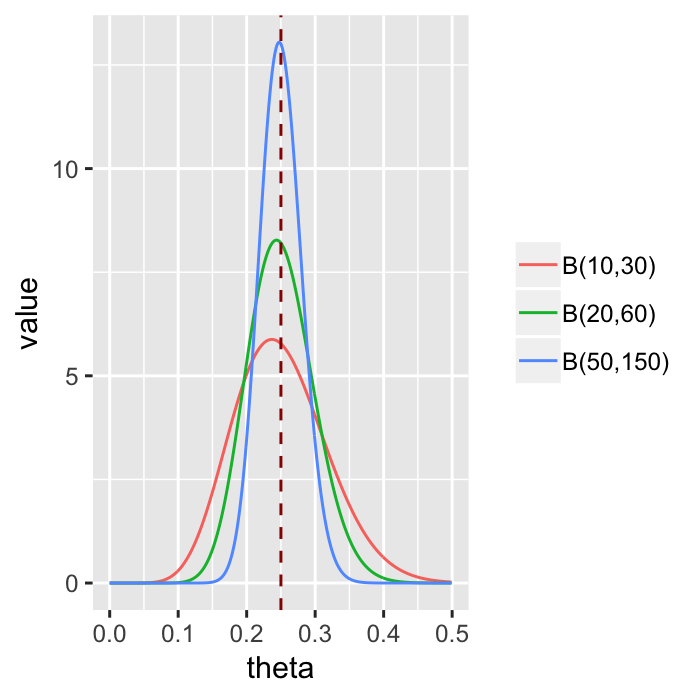

In [105]:
display(Image('http://web.stanford.edu/class/bios221/book/figure/chap2-histobeta2-1.png',width=300, height=300))

> **Figure 2.17**: Beta distributions with $\alpha = 10, 20, 50$ and $\beta = 30, 60, 150$ used as a {prior} for a probability of success. These three distributions have the same mean ($\frac{\alpha}{\alpha+\beta}$), but different concentrations around the mean.

#### The distribution of $Y$

For a given choice of $\theta$, we know what the distribution of $Y$ is, by virtue of Equation (2.5). But what is the distribution of $Y$ if $\theta$ itself also varies according to some distribution? We call this the marginal distribution of $Y$. Let’s simulate that. First we generate a random sample of 10000 $\theta$s. In the code chunk, we again use vapply to apply a function, the unnamed (or ‘anonymous’) function of th, across all elements of rtheta to obtain as a result another vector y of the same length.. For each of these 
θ
s, we then generate a random sample of 
Y
 (Figure 2.18).

In [0]:
from scipy.stats import beta
rtheta = beta.rvs(a=50, b=350, size=100000)

In [107]:
rtheta[1:10]

array([0.13226987, 0.14468313, 0.14164687, 0.13637038, 0.13118995,
       0.13090777, 0.10586661, 0.10256187, 0.12050406])

In [0]:
from scipy.stats import binom

In [0]:
y = binom.rvs(n=300,p=rtheta,size=len(rtheta))

In [110]:
y[:100]

array([29, 38, 48, 38, 30, 40, 40, 29, 31, 35, 38, 27, 32, 56, 49, 35, 50,
       47, 37, 31, 30, 33, 28, 30, 35, 29, 39, 41, 28, 38, 35, 40, 40, 43,
       40, 46, 49, 44, 34, 47, 44, 37, 38, 41, 30, 37, 38, 28, 25, 39, 34,
       36, 29, 34, 54, 40, 22, 36, 38, 34, 40, 34, 44, 30, 53, 49, 40, 35,
       34, 29, 37, 35, 38, 37, 34, 38, 49, 24, 45, 32, 36, 42, 37, 29, 37,
       35, 31, 40, 21, 41, 49, 30, 36, 40, 41, 40, 69, 58, 35, 48])

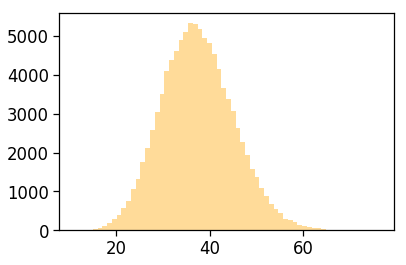

In [111]:
sns.distplot(y,kde=False,bins=64,color='orange')

>**Figure 2.18**: Marginal Distribution of $Y$

#### Histogram of all the thetas such that $Y = 40$: the posterior distribution

So let’s now compute the posterior distribution of $\theta$ by conditioning on those outcomes where $Y$ was 40.We compare it to the theoretical posterior, `densPostTheory`(We use thetas defined above in Section 2.4.), of which more below. The results are shown in Figure 2.19.

In [0]:
thetaPostEmp = rtheta[ y == 40 ]

In [0]:
densPostTheory  =  beta.pdf(thetas, 90, 610)

[(0.08, 0.18)]

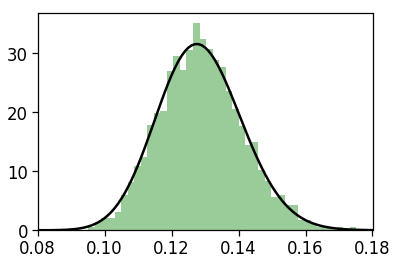

In [114]:
g = sns.distplot(thetaPostEmp, color="green", norm_hist=True, kde=False)
g = sns.lineplot(x=thetas,y=densPostTheory, color="black")
g.set(xlim=(0.08, 0.18))

>**Figure 2.19**: Only choosing the values of the distribution with $Y=40$ gives the posterior distribution of $\theta$. The histogram (green) shows the simulated values for the posteriror distribution, the line shows the theoretical density of a beta distribution with the theoretical posterior parameters.

We can also check the means of both distributions computed above and see that they are close to 4 significant digits:

In [115]:
np.mean(thetaPostEmp)

0.12889973495568013

In [116]:
np.sum(thetas*densPostTheory*(thetas[1]-thetas[0]))

0.12857142857135462

To approximate the mean of the theoretical density densPostTheory, we have above literally computed the integral $\int_0^1\theta f(\theta)d(\theta)$ using numerical integration, i.e., the sum over the integrant. This is not always convenient (or feasible), in particular if our parameters are high-dimensional, i.e., if our model involves not only a single, scalar $\theta$ parameter, but if $\theta$ is a high-dimensional object, as is for instance often the case in the case of image analysis, and if the integral cannot be computed analytically. Thus, let’s see how we could use Monte Carlo integration instead. This is similar to the code above, where we used numerical integration to compute the posterior mean from `thetaPostEmp` by calling numpy's mean function.

In [117]:
thetaPostMC = beta.rvs(a = 90, b = 610, size=1000000)
np.mean(thetaPostMC)

0.1285871128749005

We can check the concordance between our Monte Carlo sample thetaPostMC and our sample thetaPostEmp using a quantile-quantile plot (QQ-plot, Figure 2.20).

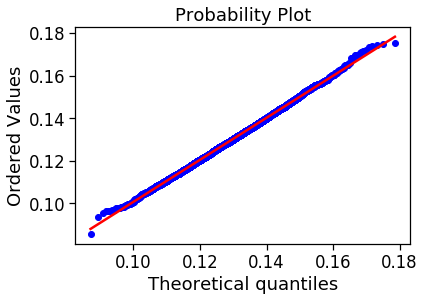

In [118]:
import pylab 
import scipy.stats as stats
stats.probplot(thetaPostEmp, dist="beta", sparams=(90,610),plot=pylab)
pylab.show()

>**Figure 2.20**: QQ-plot of our Monte Carlo sample thetaPostMC from the theoretical distribution and our simulation sample thetaPostEmp. We could also similarly compare either of these two distributions to the theoretical distribution function $B(90,610)$. If the curve lies on the line $y=x$ this indicates a good agreement. There are some random differences at the tails.

#### Posterior distribution is also a beta

Now we have seen that the posterior distribution is also a beta. In our case its parameters $\alpha=90$ and $\beta=610$ were obtained by summing the prior parameters $\alpha=50, \beta=350$ with the observed succeses $y=40$ and the observed failures $n-y=260$, thus obtaining the posterior:

$$beta(90,610)=beta(\alpha+y,\beta+(n-y))$$

We can use it to give the best estimate we can for $\theta$ with its uncertainty given by the posterior distribution: We could take the value that maximizes the posterior distribution as our best estimate, this is called the MAP estimate and this case it would be:

$$\frac{\alpha-1}{\alpha+\beta-2}=\frac{89}{698}\doteq0.1275.$$

Suppose we had a second series of data

After seeing our previous data, we now have a new prior, $\beta(90,610)$. 

 - Now we collect a new set of data with $n=150$ observations and 
$y=25$ successes, thus 125 failures. 
 - Now what would we take to be our best guess at $\theta$?
 
Using the same reasoning as before, the new posterior will be: 
 
$\beta(90+25=115, 610+125=735)$. The mean of this distribution is $\frac{115}{115+735}=\frac{115}{850}\approx0.135$, thus one estimate of $\theta$ would be 0.135.

The theoretical maximum a posteriori (MAP) estimate would be the mode of $beta(115,735)$, i.e., $\frac{114}{848}\approx0.134$. Let's check this numerically:



In [0]:
densPost2  =  beta.pdf(thetas, 115, 735)

In [0]:
mcPost2 = beta.rvs(a=115, b=735, size=100000)

In [123]:
np.sum(thetas * densPost2 * (thetas[1]-thetas[0]))

0.13529411764705052

In [124]:
np.mean(mcPost2)

0.1352303684000106

In [125]:
thetas[np.argmax(densPost2)]

0.134

&#9757; Redo all the computations replacing our original prior with a softer prior (less peaked), meaning that we use less prior information. How much does this change the final result?

As a general rule, the prior rarely changes the posterior distribution substantially except if it is very peaked. This would be the case if, at the outset, we were already rather sure of what to expect. Another case when the prior has an influence is if there is very little data.

The best situation to be in is to have enough data to swamp the prior so that its choice doesn’t have much impact on the final result.

#### Confidence Statements for the proportion parameter

Now it is time to conclude about where the proportion actually lies given the data. One summary is a posterior credibility interval, which is a Bayesian analog of the confidence interval. We can take the 2.5 and 97.5-th percentiles of the posterior distribution: $P(L \leq \theta \leq U) = 0.95$:

In [126]:
np.quantile(mcPost2,[0.025,0.975])

array([0.11319374, 0.15903634])